In [122]:
import numpy as np
import tensorflow as tf
from TextSum import helpers

In [123]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [124]:
PAD = 0
EOS = 1
vocab_size = 10
input_embedding_size = 20
encoder_hidden_units = 25
decoder_hidden_units = encoder_hidden_units

In [125]:
# encoder_inputs:[max_time, batch_size]
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
# decoder_targets: [max_time, batch_size]
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')
# decoder_inputs: [max_time, batch_size]
decoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_inputs')

In [126]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)
# encoder_inputs_embeded: [max_time, batch_size, input_embedding_size]
encoder_inputs_embeded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
# decoder_inputs_embeded: [max_time, batch_size, input_embedding_size]
decoder_inputs_embeded = tf.nn.embedding_lookup(embeddings, decoder_inputs)
decoder_inputs_embeded

<tf.Tensor 'embedding_lookup_1:0' shape=(?, ?, 20) dtype=float32>

In [127]:
encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)
encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(encoder_cell,
                                                         encoder_inputs_embeded,
                                                         dtype=tf.float32, time_major=True)
del encoder_outputs
encoder_final_state

LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 25) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 25) dtype=float32>)

In [128]:
decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units)
decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(decoder_cell, 
                                                         decoder_inputs_embeded,
                                                         initial_state=encoder_final_state,
                                                         dtype=tf.float32, time_major=True,scope='plain_decoder')

In [129]:
decoder_logits = tf.contrib.layers.linear(decoder_outputs, vocab_size)
decoder_prediction = tf.argmax(decoder_logits, 2)

In [130]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, 
                      depth=vocab_size, 
                      dtype=tf.float32),
    logits=decoder_logits)

In [131]:
loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [132]:
sess.run(tf.global_variables_initializer())

In [133]:
batch_ = [[6], [3, 4], [9, 8, 7]]

batch_, batch_length_ = helpers.batch(batch_)
print('batch_encoded:\n' + str(batch_))

din_, dlen_ = helpers.batch(np.ones(shape=(3, 1), dtype=np.int32),
                            max_sequence_length=4)
print('decoder inputs:\n' + str(din_))

pred_ = sess.run(decoder_prediction,
                 feed_dict={encoder_inputs: batch_,
                            decoder_inputs: din_,})
print('decoder predictions:\n' + str(pred_))

batch_encoded:
[[6 3 9]
 [0 4 8]
 [0 0 7]]
decoder inputs:
[[1 1 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
decoder predictions:
[[4 4 8]
 [3 3 3]
 [3 3 3]
 [3 3 3]]


In [134]:
batch_size = 10
batches = helpers.random_sequences(length_from=3, length_to=8, vocab_lower=2, 
                                   vocab_upper=10, batch_size=batch_size)
# print('head of the batch')
# for seq in next(batches):
#     print(seq)

In [135]:
def next_feed():
    batch = next(batches)
    for seq in batch:
        print(seq)
    encoder_inputs_, _ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] for sequence in batch]
    )
    decoder_inputs_, _ = helpers.batch(
        [[EOS] + (sequence) for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        decoder_inputs: decoder_inputs_,
        decoder_targets: decoder_targets_,
    }

In [146]:
a = next_feed()
a.get(encoder_inputs)

[7, 2, 5, 2, 5]
[9, 3, 7]
[8, 8, 6, 8, 6, 6, 8, 3]
[7, 5, 3, 6, 5, 3, 8, 7]
[3, 7, 2, 2, 7, 5, 4]
[2, 6, 9, 5, 5, 3, 6]
[3, 2, 6, 9]
[3, 4, 8, 5]
[8, 5, 5]
[2, 4, 6]


array([[7, 9, 8, 7, 3, 2, 3, 3, 8, 2],
       [2, 3, 8, 5, 7, 6, 2, 4, 5, 4],
       [5, 7, 6, 3, 2, 9, 6, 8, 5, 6],
       [2, 0, 8, 6, 2, 5, 9, 5, 0, 0],
       [5, 0, 6, 5, 7, 5, 0, 0, 0, 0],
       [0, 0, 6, 3, 5, 3, 0, 0, 0, 0],
       [0, 0, 8, 8, 4, 6, 0, 0, 0, 0],
       [0, 0, 3, 7, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [147]:
a.get(decoder_inputs)

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [7, 9, 8, 7, 3, 2, 3, 3, 8, 2],
       [2, 3, 8, 5, 7, 6, 2, 4, 5, 4],
       [5, 7, 6, 3, 2, 9, 6, 8, 5, 6],
       [2, 0, 8, 6, 2, 5, 9, 5, 0, 0],
       [5, 0, 6, 5, 7, 5, 0, 0, 0, 0],
       [0, 0, 6, 3, 5, 3, 0, 0, 0, 0],
       [0, 0, 8, 8, 4, 6, 0, 0, 0, 0],
       [0, 0, 3, 7, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [148]:
a.get(decoder_targets)

array([[7, 9, 8, 7, 3, 2, 3, 3, 8, 2],
       [2, 3, 8, 5, 7, 6, 2, 4, 5, 4],
       [5, 7, 6, 3, 2, 9, 6, 8, 5, 6],
       [2, 1, 8, 6, 2, 5, 9, 5, 1, 1],
       [5, 0, 6, 5, 7, 5, 1, 1, 0, 0],
       [1, 0, 6, 3, 5, 3, 0, 0, 0, 0],
       [0, 0, 8, 8, 4, 6, 0, 0, 0, 0],
       [0, 0, 3, 7, 1, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [149]:
a[encoder_inputs].T

array([[7, 2, 5, 2, 5, 0, 0, 0],
       [9, 3, 7, 0, 0, 0, 0, 0],
       [8, 8, 6, 8, 6, 6, 8, 3],
       [7, 5, 3, 6, 5, 3, 8, 7],
       [3, 7, 2, 2, 7, 5, 4, 0],
       [2, 6, 9, 5, 5, 3, 6, 0],
       [3, 2, 6, 9, 0, 0, 0, 0],
       [3, 4, 8, 5, 0, 0, 0, 0],
       [8, 5, 5, 0, 0, 0, 0, 0],
       [2, 4, 6, 0, 0, 0, 0, 0]], dtype=int32)

In [154]:
for i, (aa, bbb) in enumerate(zip(a[encoder_inputs].T, a[encoder_inputs].T)):
    print('a.{}'.format(aa))
    print('b.{}'.format(bbb))


a.[7 2 5 2 5 0 0 0]
b.[7 2 5 2 5 0 0 0]
a.[9 3 7 0 0 0 0 0]
b.[9 3 7 0 0 0 0 0]
a.[8 8 6 8 6 6 8 3]
b.[8 8 6 8 6 6 8 3]
a.[7 5 3 6 5 3 8 7]
b.[7 5 3 6 5 3 8 7]
a.[3 7 2 2 7 5 4 0]
b.[3 7 2 2 7 5 4 0]
a.[2 6 9 5 5 3 6 0]
b.[2 6 9 5 5 3 6 0]
a.[3 2 6 9 0 0 0 0]
b.[3 2 6 9 0 0 0 0]
a.[3 4 8 5 0 0 0 0]
b.[3 4 8 5 0 0 0 0]
a.[8 5 5 0 0 0 0 0]
b.[8 5 5 0 0 0 0 0]
a.[2 4 6 0 0 0 0 0]
b.[2 4 6 0 0 0 0 0]


In [155]:
loss_track = []

In [51]:
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()
except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.323730707168579


  sample 1:
    input     > [4 8 9 8 2 0 0 0]
    predicted > [3 3 9 9 9 4 2 2 2]
  sample 2:
    input     > [8 6 5 5 0 0 0 0]
    predicted > [3 3 8 4 4 4 5 5 5]
  sample 3:
    input     > [5 3 9 5 6 9 7 0]
    predicted > [3 4 9 9 9 9 9 9 3]



batch 1000
  minibatch loss: 0.2517053186893463
  sample 1:
    input     > [7 6 3 7 2 0 0 0]
    predicted > [7 6 3 7 2 1 0 0 0]
  sample 2:
    input     > [2 9 4 2 8 0 0 0]
    predicted > [2 9 4 2 8 1 0 0 0]
  sample 3:
    input     > [3 8 9 8 7 5 9 0]
    predicted > [3 8 9 8 5 5 9 1 0]



batch 2000
  minibatch loss: 0.13324221968650818
  sample 1:
    input     > [9 4 9 0 0 0 0 0]
    predicted > [9 4 9 1 0 0 0 0 0]
  sample 2:
    input     > [8 9 2 2 5 5 3 3]
    predicted > [2 9 2 5 5 3 3 3 1]
  sample 3:
    input     > [2 6 8 7 8 0 0 0]
    predicted > [2 6 8 7 8 1 0 0 0]



batch 3000
  minibatch loss: 0.08200498670339584
  sample 1:
    input     > [2 8 8 3 7 0 0 0]
    predicted > [2 8 8 3 7 1 0 0 0]
  sample 2:
    input     > [9 7 2 4 9 8 0 0]
    predicted > [9 7 2 4 9 8 1 0 0]
  sample 3:
    input     > [5 2 6 9 0 0 0 0]
    predicted > [5 2 6 9 1 0 0 0 0]



loss 0.0834 after 300100 examples (batch_size=100)


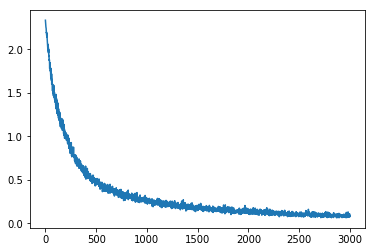

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], 
                                                             len(loss_track)*batch_size, 
                                                             batch_size))